In [1]:
# Import some basic libraries and functions for this tutorial.
import numpy as np
import os

from dataclasses import dataclass

from pydrake.common import FindResourceOrThrow, temp_directory
from pydrake.geometry import (
    MeshcatVisualizer,
    MeshcatVisualizerParams,
    Role,
    StartMeshcat,
)
from pydrake.math import RigidTransform, RollPitchYaw
from pydrake.multibody.parsing import Parser
from pydrake.multibody.plant import AddMultibodyPlantSceneGraph
from pydrake.systems.analysis import Simulator
from pydrake.systems.framework import DiagramBuilder
from pydrake.visualization import ModelVisualizer

from pydrake.geometry import Rgba
from pydrake.geometry import MeshcatVisualizerParams
from pydrake.common.eigen_geometry import Quaternion

import time

In [2]:
# Start the visualizer. The cell will output an HTTP link after the execution.
# Click the link and a MeshCat tab should appear in your browser.
meshcat = StartMeshcat()

INFO:drake:Meshcat listening for connections at http://localhost:7001


In [3]:
# First we'll locate one of Drake's example model files, a KUKA iiwa arm.
# Note that FindResourceOrThrow() is only used for models included with Drake.
# Don't use FindResourceOrThrow for your own models.
# iiwa7_model_file = FindResourceOrThrow(
#     "drake/manipulation/models/"
#     "iiwa_description/iiwa7/iiwa7_with_box_collision.sdf")

slider_main_model_file = "./models/urdf/slider_2_0_urdf.urdf"
slider_aux_model_file = "./models/urdf/slider_2_0_urdf-transparent.urdf"

# Create a model visualizer and add the robot arm.
# visualizer = ModelVisualizer(meshcat=meshcat)
# visualizer.AddModels(slider_main_model_file)

# visualizer.Run()

builder = DiagramBuilder()
plant, scene_graph = AddMultibodyPlantSceneGraph(builder, 0.0)

parser = Parser(plant)
slider_main = parser.AddModelFromFile(slider_main_model_file, model_name="slider_main")
slider_aux = parser.AddModelFromFile(slider_aux_model_file, model_name="slider_2")

meshcat_vis = MeshcatVisualizer.AddToBuilder(builder = builder, scene_graph = scene_graph, meshcat = meshcat, params = MeshcatVisualizerParams(default_color = Rgba(1, 0, 0, 0)))

plant.Finalize()
diagram = builder.Build()

# Simulator(diagram).Initialize()
diagram_context = diagram.CreateDefaultContext()


In [ ]:
diagram_context.geometr

In [4]:
plant_context = plant.GetMyContextFromRoot(diagram_context)

# Main Robot
base_link_main = plant.GetJointByName("$world_base_link", slider_main)

left_roll_main = plant.GetJointByName('Left_Roll', slider_main)
left_pitch_main = plant.GetJointByName('Left_Pitch', slider_main)
left_slide_main = plant.GetJointByName('Left_Slide', slider_main)
left_foot_roll_main = plant.GetJointByName('Left_Foot_Roll', slider_main)
left_foot_pitch_main = plant.GetJointByName('Left_Foot_Pitch', slider_main)

right_roll_main = plant.GetJointByName('Right_Roll', slider_main)
right_pitch_main = plant.GetJointByName('Right_Pitch', slider_main)
right_slide_main = plant.GetJointByName('Right_Slide', slider_main)
right_foot_roll_main = plant.GetJointByName('Right_Foot_Roll', slider_main)
right_foot_pitch_main = plant.GetJointByName('Right_Foot_Pitch', slider_main)


# Aux Robot
base_link_aux = plant.GetJointByName("$world_base_link", slider_aux)

left_roll_aux = plant.GetJointByName('Left_Roll', slider_aux)
left_pitch_aux = plant.GetJointByName('Left_Pitch', slider_aux)
left_slide_aux = plant.GetJointByName('Left_Slide', slider_aux)
left_foot_roll_aux = plant.GetJointByName('Left_Foot_Roll', slider_aux)
left_foot_pitch_aux = plant.GetJointByName('Left_Foot_Pitch', slider_aux)

right_roll_aux = plant.GetJointByName('Right_Roll', slider_aux)
right_pitch_aux = plant.GetJointByName('Right_Pitch', slider_aux)
right_slide_aux = plant.GetJointByName('Right_Slide', slider_aux)
right_foot_roll_aux = plant.GetJointByName('Right_Foot_Roll', slider_aux)
right_foot_pitch_aux = plant.GetJointByName('Right_Foot_Pitch', slider_aux)

In [195]:
right_foot_roll_main.set_angle(plant_context, -0.0)
right_pitch_main.set_angle(plant_context, 0.0)
right_roll_main.set_angle(plant_context, 0.0)
right_slide_main.set_translation(plant_context, 0.0)

base_link_main.set_position(plant_context, np.array([0.5, 0, 0]))

quat = np.array([0.5, 0.0, 0, 0])
quat = Quaternion(quat / np.linalg.norm(quat))
base_link_main.set_quaternion(plant_context, quat)

def set_q_main(q):
    left_roll_main.set_angle(plant_context, q[0]),
    left_pitch_main.set_angle(plant_context, q[1])
    left_slide_main.set_translation(plant_context, q[2])
    left_foot_roll_main.set_angle(plant_context, q[3])
    left_foot_pitch_main.set_angle(plant_context, q[4])

    right_roll_main.set_angle(plant_context, q[5])
    right_pitch_main.set_angle(plant_context, q[6])
    right_slide_main.set_translation(plant_context, q[7])
    right_foot_roll_main.set_angle(plant_context, q[8])
    right_foot_pitch_main.set_angle(plant_context, q[9])

def get_q_main():
    q_main = [
        left_roll_main.get_angle(plant_context),
        left_pitch_main.get_angle(plant_context),
        left_slide_main.get_translation(plant_context),
        left_foot_roll_main.get_angle(plant_context),
        left_foot_pitch_main.get_angle(plant_context),

        right_roll_main.get_angle(plant_context),
        right_pitch_main.get_angle(plant_context),
        right_slide_main.get_translation(plant_context),
        right_foot_roll_main.get_angle(plant_context),
        right_foot_pitch_main.get_angle(plant_context)
    ]
    return q_main


# Calculates relative robot position based on orientation and joint angles
contact_point = np.array([0,0,0])
current_contact_frame = ""
previous_contact_frame = "Left_Foot"


velocity_estimate = np.zeros(3)
previous_body_pos = np.zeros(3)

def get_world_position_of_frame(name, robot):
    frame = plant.GetFrameByName(name, robot)
    frame_pose = frame.CalcPoseInWorld(plant_context)
    frame_position = np.array(frame_pose.translation())

    return frame_position

def calculate_rel_robot_position(quaternion, q, initial = False):
    time_dt = 0.02
    global previous_contact_frame
    global current_contact_frame
    global previous_body_pos
    global velocity_estimate
    global contact_point

    base_link_aux.set_quaternion(plant_context, quaternion)

    # base_link_aux.set_position(plant_context, [0,0,0])

    # Copy joint angles
    left_roll_aux.set_angle(plant_context, q[0])
    left_pitch_aux.set_angle(plant_context, q[1])
    left_slide_aux.set_translation(plant_context, q[2])
    left_foot_roll_aux.set_angle(plant_context, q[3])
    left_foot_pitch_aux.set_angle(plant_context, q[4])

    right_roll_aux.set_angle(plant_context, q[5])
    right_pitch_aux.set_angle(plant_context, q[6])
    right_slide_aux.set_translation(plant_context, q[7])
    right_foot_roll_aux.set_angle(plant_context, q[8])
    right_foot_pitch_aux.set_angle(plant_context, q[9])

    base_frame_position = get_world_position_of_frame("base_link", slider_aux)

    left_foot_world_position = get_world_position_of_frame("Left_Foot", slider_aux) - np.array([0,0,0.03])
    left_foot_rel_position = left_foot_world_position - base_frame_position
    right_foot_world_position = get_world_position_of_frame("Right_Foot", slider_aux) - np.array([0,0,0.03])
    right_foot_rel_position = right_foot_world_position - base_frame_position

    # Contact point relative to robot base link
    # print("Left_Foot", left_foot_world_position)
    # print("Right_Foot", right_foot_world_position)

    # If left foot is lower than right foot, assume it is in contact with the ground

    if(left_foot_world_position[2] < right_foot_world_position[2]):
        contact_offset = left_foot_rel_position
        current_contact_frame = "Left_Foot"
    else:
        contact_offset = right_foot_rel_position
        current_contact_frame = "Right_Foot"

    # if(abs(left_foot_world_position[2] - right_foot_world_position[2]) < 0.01):
    #     contact_offset = (left_foot_rel_position + right_foot_rel_position) / 2.0
    #     current_contact_frame = "Middle"

    if(current_contact_frame != previous_contact_frame and not initial):
        # base_link_aux.set_position(plant_context, contact_point - contact_offset)
        #if(current_contact_frame == "Middle"):
        #    next_contact_point = (left_foot_world_position + right_foot_world_position) / 2.0
        #else:
        prev_contact_offset = get_world_position_of_frame(previous_contact_frame, slider_aux) - base_frame_position
        base_link_aux.set_position(plant_context, contact_point - prev_contact_offset)

        contact_point = get_world_position_of_frame(current_contact_frame, slider_aux)
    
    if(initial):
        contact_point = [0, -0.2, 0]

    # Set contact point on the ground
    contact_point[2] = 0

    base_link_aux.set_position(plant_context, contact_point - contact_offset)

    previous_contact_frame = current_contact_frame

    # Update velocity estimate
    current_body_pos = get_world_position_of_frame("base_link", slider_aux);
    velocity_estimate = (current_body_pos - previous_body_pos) / time_dt
    previous_body_pos = current_body_pos
    # print(velocity_estimate)


calculate_rel_robot_position(base_link_main.get_quaternion(plant_context), get_q_main(), True)

# print(base_link_main.get_pose(plant_context))

diagram.ForcedPublish(diagram_context)

In [13]:
# calculate_rel_robot_position(base_link_main.get_quaternion(plant_context), get_q_main(), True)

for t in range(1000):
    quat = np.array([0.5, 0.1 * np.sin(t * 0.03), 0, 0])
    quat = Quaternion(quat / np.linalg.norm(quat))
    base_link_main.set_quaternion(plant_context, quat)
    
    right_pitch_main.set_angle(plant_context, 0.3 * np.cos(t * 0.03))

    calculate_rel_robot_position(base_link_main.get_quaternion(plant_context), get_q_main())

    diagram.ForcedPublish(diagram_context)
    time.sleep(0.01)

In [227]:
calculate_rel_robot_position(base_link_main.get_quaternion(plant_context), get_q_main(), True)
diagram.ForcedPublish(diagram_context)


from SliderEnv import SliderEnv
import time
import os
import glob
import numpy as np

from stable_baselines3 import PPO

import matplotlib
from matplotlib import pyplot as plt

import copy

env = SliderEnv()

model = PPO("MlpPolicy", env, verbose=1, learning_rate = 0.0005, 
      tensorboard_log="./trained_models/tensorboard")
# n_steps = int(8192 * 0.5),
timesteps = 100_000
total_timesteps = 0

trial_name = "weaker-pid-step-time-0-6"
model_save_path = "./trained_models/" + trial_name

model =  PPO.load(model_save_path + "/model-20", env=env)

forward = False

speed = 1.0

env.step_time = 0.6
env.sim_steps = 10

force_data = []
vel_data = []

while True:
      # Reset enviroment
      obs = env.reset()
      # Render things
      for i in range(2000):

            action, _state = model.predict(obs, deterministic=True)

            obs, reward, done, info = env.step(action)
            env.render()

            ground_truth_position = env.data.qpos[0:3]
            # print(ground_truth_position)

            base_link_main.set_position(plant_context, ground_truth_position)

            obs = obs + np.random.randn(obs.shape[0]) * 0.001

            ## print([obs[1], obs[2], obs[3]])
            vel_data.append(obs[1])
            obs[1:4] = velocity_estimate
            obs[0] = 0.5

            quat = np.array([obs[10] * 1.1, 
                             obs[11] * 1.1, 
                             obs[12] * 1.1, 
                             obs[13] * 1.1])
            quat = quat / np.linalg.norm(quat)
            quat = Quaternion(quat)

            base_link_main.set_quaternion(plant_context, quat)

            set_q_main([
                  obs[18],
                  obs[22],
                  obs[14],
                  obs[30],
                  obs[26],

                  obs[20],
                  obs[24],
                  obs[16],
                  obs[32],
                  obs[28],
            ])

            obs = obs + np.random.randn(obs.shape[0]) * 0.01

            calculate_rel_robot_position(base_link_main.get_quaternion(plant_context), get_q_main())
            diagram.ForcedPublish(diagram_context)

            force_data.append(copy.copy(env.data.sensor("left-foot-touch").data))


            time.sleep(0.015)
      
      break


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


KeyboardInterrupt: 

In [226]:
env.close()

1000


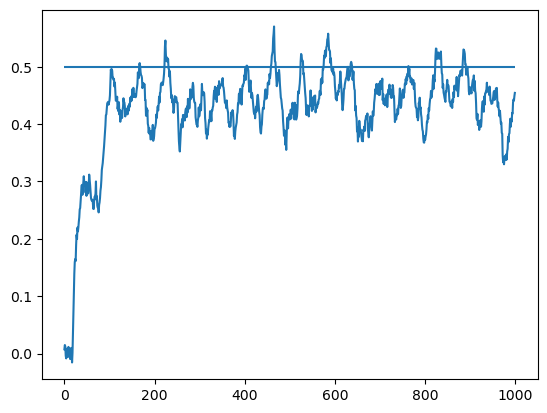

In [154]:
print(len(vel_data))
plt.plot(vel_data)
plt.hlines([0.5], 0, 1000)

In [53]:
from pydrake.common.eigen_geometry import Quaternion
import numpy as np

def normalize(w,x,y,z):
        quat = np.array([w,x,y,z])
        return quat/np.linalg.norm(quat)

v1 = np.array([0, 0, 1])
v2 = np.array([0, 1, 1])

v_cross = np.array([v1[1] * v2[2] - v1[2] * v2[1],
                   v1[2] * v2[0] - v1[0] * v2[2],
                   v1[0] * v2[1] - v1[1] * v2[0]])
# v_cross = np.cross(v1, v2)

quat = np.zeros(4)

quat[0] = (np.linalg.norm(v1) * np.linalg.norm(v2)) + v1.dot(v2)
quat[1:4] = v_cross

quat = quat/np.linalg.norm(quat)

print(quat)


[ 0.92387953 -0.38268343  0.          0.        ]


In [115]:
w = [0, 1.0 * np.pi, 0, 0] # rads/s
q0 = np.array([1, 0, 0, 0])

# * np.pi

def q_mul(q1, q2):
    w1, x1, y1, z1 = q1
    w2, x2, y2, z2 = q2
    w = w1 * w2 - x1 * x2 - y1 * y2 - z1 * z2
    x = w1 * x2 + x1 * w2 + y1 * z2 - z1 * y2
    y = w1 * y2 + y1 * w2 + z1 * x2 - x1 * z2
    z = w1 * z2 + z1 * w2 + x1 * y2 - y1 * x2
    return np.array([w, x, y, z])

def inv(q1):
    w1, x1, y1, z1 = q1
    return np.array([w1, -x1, -y1, -z1])

t_step = 0.01
for i in range(0, 100):
    q0 = q0 + (t_step / 2.0) * q_mul(w, q0)
    q0 = q0/np.linalg.norm(q0)

# 0.5 * q_mul(w, q0)

q0

array([1.29173696e-04, 9.99999992e-01, 0.00000000e+00, 0.00000000e+00])

In [100]:

imu_quat = np.array([0, 1, 0, 0])
imu_quat = imu_quat / np.linalg.norm(imu_quat)

print(w)
print(q_mul(q_mul(imu_quat, w), inv(imu_quat)))

[0, 0, 3.141592653589793, 0]
[ 0.          0.         -3.14159265  0.        ]


array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])